In [74]:
"""
GTSAM Copyright 2010-2018, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)
See LICENSE for the license information
An example of running visual SLAM using iSAM2.
Author: Duy-Nguyen Ta (C++), Frank Dellaert (Python)
"""
# pylint: disable=invalid-name, E1101

from __future__ import print_function

import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt
import numpy as np
from gtsam.symbol_shorthand import L, X
from gtsam.examples import SFMdata
import time
import random#
from icecream import ic
%matplotlib widget
from ipywidgets import *
def visual_ISAM2_plot(result, gt_poses):
    """
    VisualISAMPlot plots current state of ISAM2 object
    Author: Ellon Paiva
    Based on MATLAB version by: Duy Nguyen Ta and Frank Dellaert
    """

    # Declare an id for the figure
    fignum = 0

    fig = plt.figure(fignum)
    axes = fig.gca(projection='3d')
    plt.cla()

    # Plot points
    # Can't use data because current frame might not see all points
    # marginals = Marginals(isam.getFactorsUnsafe(), isam.calculateEstimate())
    # gtsam.plot_3d_points(result, [], marginals)
    gtsam_plot.plot_3d_points(fignum, result, 'rx')

    # Plot cameras
    i = 0
    #2d result plo
    result_pose = []
    gt_pose = []
    
    while result.exists(i):
        pose_i = result.atPose3(i)
        gtsam_plot.plot_pose3(fignum, pose_i, 10)
        gtsam_plot.plot_pose3(fignum, gt_poses[i], 5)
        result_pose.append(np.array([pose_i.x(),pose_i.y(),pose_i.z()]))
        gt_pose.append(np.array([gt_poses[i].x(),gt_poses[i].y(),gt_poses[i].z()]))
        i += 1

    result_pose = np.array(result_pose)
    plt.plot(result_pose[:,0],result_pose[:,1],result_pose[:,2],'r')
    gt_pose = np.array(gt_pose)
    plt.plot(gt_pose[:,0],gt_pose[:,1],gt_pose[:,2],'b')
    plt.show()

    # draw
    axes.set_xlim3d(-40, 40)
    axes.set_ylim3d(-40, 40)
    axes.set_zlim3d(-40, 40)
    plt.pause(0.2)


In [75]:

plt.ion()

# Define the camera calibration parameters
K = gtsam.Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(
    2, 1.0)  # one pixel in u and v

# Create the set of ground-truth landmarks
points = SFMdata.createPoints()
points += [p for p in points]
points += [p for p in points]
points = [(i, point) for (i, point) in enumerate(points)]
ic(points)
# Create the set of ground-truth poses
poses = SFMdata.createPoses(K)
# Create an iSAM2 object. Unlike iSAM1, which performs periodic batch steps
# to maintain proper linearization and efficient variable ordering, iSAM2
# performs partial relinearization/reordering at each step. A parameter
# structure is available that allows the user to set various properties, such
# as the relinearization threshold and type of linear solver. For this
# example, we we set the relinearization threshold small so the iSAM2 result
# will approach the batch result.
parameters = gtsam.ISAM2Params()
parameters.setRelinearizeThreshold(0.01)
# parameters.relinearizeSkip = 1
isam = gtsam.ISAM2(parameters)

# Create a Factor Graph and Values to hold the new data
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# debug
optimize_time = 0
noise = 1


ic| points: [(0, array([10., 10., 10.])),
             (1, array([-10.,  10.,  10.])),
             (2, array([-10., -10.,  10.])),
             (3, array([ 10., -10.,  10.])),
             (4, array([ 10.,  10., -10.])),
             (5, array([-10.,  10., -10.])),
             (6, array([-10., -10., -10.])),
             (7, array([ 10., -10., -10.])),
             (8, array([10., 10., 10.])),
             (9, array([-10.,  10.,  10.])),
             (10, array([-10., -10.,  10.])),
             (11, array([ 10., -10.,  10.])),
             (12, array([ 10.,  10., -10.])),
             (13, array([-10.,  10., -10.])),
             (14, array([-10., -10., -10.])),
             (15, array([ 10., -10., -10.])),
             (16, array([10., 10., 10.])),
             (17, array([-10.,  10.,  10.])),
             (18, array([-10., -10.,  10.])),
             (19, array([ 10., -10.,  10.])),
             (20, array([ 10.,  10., -10.])),
             (21, array([-10.,  10., -10.])),
       

In [76]:
rotate = poses[0].rotation()
translation =  poses[0].rotation()
newpose =gtsam.Pose3(rotate,np.array([ poses[0].x()+0.1, poses[0].y()+0.1, poses[0].z()+0.1]))
poses.append(newpose)
points_new = []
for i,point in points:
    points_new.append((len(points) + i,point*1.1))
    if i == 0:
        break
ic(points_new)
# points = points_new


ic| points_new: [(32, array([11., 11., 11.]))]


[(32, array([11., 11., 11.]))]

/tmp/ipykernel_28788/2014045464.py:36: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')
/home/luke/Archive/Application/anaconda3/lib/python3.9/site-packages/gtsam/utils/plot.py:229: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')
/home/luke/Archive/Ap

****************************************************
Frame 1 :


TypeError: list indices must be integers or slices, not tuple

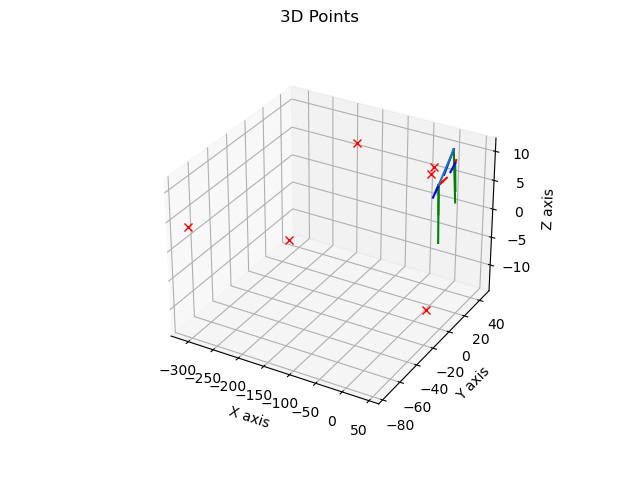

In [77]:

    #  Loop over the different poses, adding the observations to iSAM incrementally
    for i, pose in enumerate(poses):
        #if i==5:
        points=points[0:5]
        noise = 3
        #Add factors for each landmark observation
        for j, point in points:
            camera = gtsam.PinholeCameraCal3_S2(pose, K)
            measurement = camera.project(point) + np.random.normal(0, noise)
            
            graph.add(gtsam.GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, i, 100 + j, K))
        if i <= 8:
            for j, point in points_new:
                camera = gtsam.PinholeCameraCal3_S2(pose, K)
                measurement = camera.project(point) + np.random.normal(0, noise)
                
                graph.add(gtsam.GenericProjectionFactorCal3_S2(
                    measurement, measurement_noise, i, 105, K))
       
           
        # if i == 8:
        #     covariance = np.eye(6)
        #     odometry_noise = gtsam.noiseModel.Gaussian.Covariance(covariance)
        #     R = np.eye(3)
        #     rotation = gtsam.Rot3(R)
        #     P3 = gtsam.Pose3(rotation,np.array([-0.1,-0.1,-0.1]).reshape(-1,1))
        #     graph.add(gtsam.BetweenFactorPose3(0,7,P3,odometry_noise))
        # Add an initial guess for the current pose
        # Intentionally initialize the variables off from the ground truth
        if i<=3:
            # initial_estimate.insert(X(i), pose)
            initial_estimate.insert(i, pose.compose(gtsam.Pose3(
                gtsam.Rot3.Rodrigues(-0.1, 0.2, 0.15), gtsam.Point3(1, -1, 1))))
        else:
            initial_estimate.insert(i, current_estimate.atPose3(i-1))

        # If this is the first iteration, add a prior on the first pose to set the
        # coordinate frame and a prior on the first landmark to set the scale.
        # Also, as iSAM solves incrementally, we must wait until each is observed
        # at least twice before adding it to iSAM.
        if i == 0:
            # Add a prior on pose x0
            pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array(
                [0.1, 0.1, 0.1, 0.3, 0.3, 0.3]))  # 30cm std on x,y,z 0.1 rad on roll,pitch,yaw
            graph.push_back(gtsam.PriorFactorPose3(0, poses[0], pose_noise))

            # Add a prior on landmark l0
            point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
            graph.push_back(gtsam.PriorFactorPoint3(
                100, points[0][1], point_noise))  # add directly to graph

            # Add initial guesses to all observed landmarks
            # Intentionally initialize the variables off from the ground truth
            for j, point in points:
                initial_estimate.insert(100+j, gtsam.Point3(
                    point[0]-0.25, point[1]+0.20, point[2]+0.15))
            for j, point in points_new:
                initial_estimate.insert(105, gtsam.Point3(
                    point[0]-0.25, point[1]+0.20, point[2]+0.15))
        else:
            # Update iSAM with the new factors
            start = time.time()
            isam.update(graph, initial_estimate)
            # Each call to iSAM2 update(*) performs one iteration of the iterative nonlinear solver.
            # If accuracy is desired at the expense of time, update(*) can be called additional
            # times to perform multiple optimizer iterations every step.
            isam.update()
            current_estimate = isam.calculateEstimate()
            optimize_time += time.time()-start
            print("****************************************************")
            print("Frame", i, ":")
            # for j in range(i + 1):
            #     print(X(j), ":", current_estimate.atPose3(X(j)))

            # for j in range(len(points)):
            #     print(L(j), ":", current_estimate.atPoint3(L(j)))

            # print('===================')
            # print('estimated: ', current_estimate.atPose3(X(i)))
            # print('gt: ', pose)

            visual_ISAM2_plot(current_estimate, poses)

            # Clear the factor graph and values for the next iteration
            graph.resize(0)
            initial_estimate.clear()

    print('optimize_time: ', optimize_time)
    # plt.ioff()
    # plt.show()


In [ ]:

    # remove a amount of measument
    # isam.remove
    # ic(vi.at())
    # #ic(gtsam.symbol("L",32).selfToKey())
    # vi = gtsam.VariableIndex(graph)
    # vi.print()
    # ic(isam.getFactorsUnsafe().size())
    # #isam.update(gtsam.NonlinearFactorGraph(), gtsam.Values(),[isam.getFactorsUnsafe().size()-1])
    # ic(isam.getFactorsUnsafe().)
    
    
    vi = isam.getVariableIndex()
    vi.print()
    # graph.remove(graph.keys().size()-2)
    # graph.remove(graph.keys().size()-1)
    measurement_add = []
    factor_key = 105
    graph.print()
    factor_remove = []
    for index in range(isam.getFactorsUnsafe().size()):
        factor = isam.getFactorsUnsafe().at(index)
        key = factor.keys()
        if (len(key) == 2):
            key = key[1]
            if (key == factor_key):
                factor_remove.append(index)
    ic(factor_remove)
    for n in factor_remove:
        measurement_add.append((isam.getFactorsUnsafe().at(n).keys(),isam.getFactorsUnsafe().at(n).measured()))
    isam.update(gtsam.NonlinearFactorGraph(), gtsam.Values(),factor_remove)
    current_estimate = isam.calculateEstimate()
    for n in measurement_add:
        graph.add(gtsam.GenericProjectionFactorCal3_S2(
            n[1], measurement_noise, n[0][0], 100, K))
        #initial_estimate.insert(n[0][0], current_estimate.atPose3(n[0][0]))
    vi = isam.getVariableIndex()
    
    # vi.print()
    # swapfactors = gtsam.NonlinearFactorGraph()
    # camera = gtsam.PinholeCameraCal3_S2(pose, K)
    # measurement = camera.project(point) + np.random.normal(0, noise)
        
    # swapfactors.add(gtsam.GenericProjectionFactorCal3_S2(
    #          measurement, measurement_noise, i, 100, K))
    graph.at(graph.size()-1).print()
    graph.remove(graph.size()-2)
    graph.print()
    isam.update(graph, initial_estimate)
    isam.getVariableIndex().print()
    current_estimate = isam.calculateEstimate()
    visual_ISAM2_plot(current_estimate, poses)

    # graph.push_back(swapfactors)
    # initial_estimate.insert(i, current_  isam.update(graph,)estimate.atPose3(i-1))
    
    # isam.update(swapfactors, initial_estimate,[4,11,16,21,26,31,36,41])
    # initial_estimate.clear()
    #isam.removeVariables()

VariableIndex: nEntries = 108, nFactors = 65
var 0: 0 1 2 3 4 6 56
var 1: 8 9 10 11 12 57
var 2: 14 15 16 17 18 58
var 3: 20 21 22 23 24 59
var 4: 26 27 28 29 30 60
var 5: 32 33 34 35 36 61
var 6: 38 39 40 41 42 62
var 7: 44 45 46 47 48
var 8: 50 51 52 53 54 64
var 100: 0 7 8 14 20 26 32 38 44 50 56 57 58 59 60 61 62 64
var 101: 1 9 15 21 27 33 39 45 51
var 102: 2 10 16 22 28 34 40 46 52
var 103: 3 11 17 23 29 35 41 47 53
var 104: 4 12 18 24 30 36 42 48 54
NonlinearFactorGraph: size: 9

Factor 0: GenericProjectionFactor, z = [
	71.0661;
	36.999
]
  keys = { 0 100 }
  noise model: unit (2) 

Factor 1: GenericProjectionFactor, z = [
	51.4066;
	36.7108
]
  keys = { 1 100 }
  noise model: unit (2) 

Factor 2: GenericProjectionFactor, z = [
	32.6009;
	37.9722
]
  keys = { 2 100 }
  noise model: unit (2) 

Factor 3: GenericProjectionFactor, z = [
	33.5567;
	39.8902
]
  keys = { 3 100 }
  noise model: unit (2) 

Factor 4: GenericProjectionFactor, z = [
	39.7576;
	37.3818
]
  keys = { 4 100 }


AttributeError: 'NoneType' object has no attribute 'keys'

[ 40.00380257  27.82373093   5.99612942 -19.06211844 -32.69927386
  -9.95471181  44.70474728  56.25271593  -3.87874026]


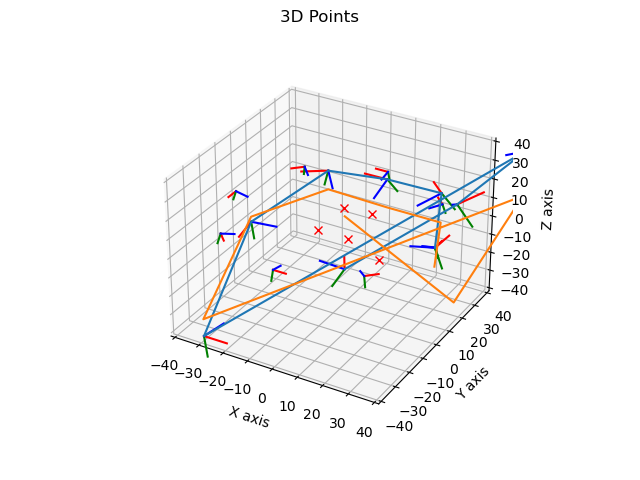

In [ ]:
# #2d result plo
# result = current_estimate
# i = 0
# result_pose = []
# while result.exists(i):
#     pose_i = result.atPose3(i)
#     result_pose.append(np.array([pose_i.x(),pose_i.y()]))
#     i=i+1
# result_pose = np.array(result_pose)
# print(result_pose[:,0])
# plt.plot(result_pose[:,0],result_pose[:,1])
# plt.show()